In [ ]:
!pip3 install --upgrade pip
!pip3 install --upgrade transformers
!pip3 install --upgrade accelerate
!pip3 install sentencepiece
!pip install pytesseract transformers datasets rouge-score nltk tensorboard py7zr --upgrade
!pip install ipywidgets
!pip install peft
!pip install bitsandbytes
!pip install evaluate
!pip install trl


In [ ]:
# !pip uninstall transformers
!pip install transformers==4.45.2
!pip install git+https://github.com/huggingface/trl
!pip install --upgrade huggingface_hub

In [ ]:
!unzip relations.zip
!unzip tacred_all_data.zip

In [ ]:
!huggingface-cli login --token your_token


In [ ]:
import torch
import json
import evaluate
import nltk, torch
import numpy as np
nltk.download("punkt")
from transformers import TrainerCallback
from sklearn.metrics import precision_recall_fscore_support
from peft import LoraConfig
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss
from torch.nn import CrossEntropyLoss
import numpy as np
from copy import deepcopy
from transformers import TrainerCallback
from peft import AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, AutoModelForSeq2SeqLM
import numpy as np
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import load_dataset

metric = evaluate.load("rouge")
from peft import  get_peft_model, LoraConfig, TaskType



def set_tokenizer(model_id="google/flan-t5-base"):


    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return tokenizer


def load_model(model_id="google/flan-t5-base", local=False):

    compute_dtype = getattr(torch, "float16")
    # load model from the hub
    # maxmem={i:f'{int(torch.cuda.mem_get_info()[0]/1024**3)-2}GB' for i in range()}
    # maxmem['cpu']='300GB'
    bnb_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=False,
    )

    # model = AutoModelForSeq2SeqLM.from_pretrained(model_id,  device_map="auto", max_memory=maxmem, quantization_config=bnb_config)
    if local:
      model = AutoModelForSeq2SeqLM.from_pretrained(model_id,  device_map="auto", quantization_config=bnb_config, local_files_only=True)
    else:
      model = AutoModelForSeq2SeqLM.from_pretrained(model_id,  device_map="auto", quantization_config=bnb_config)

    return model




In [ ]:
import json
def read_json(path):
    with open(path, 'r', encoding="utf-8") as f:
        data = json.load(f)
    return data

def write_json(data, path):
    with open(path, 'w', encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

In [ ]:
##embedding computation
def compute_embedding(model, tokenizer, input_path, model_type="Encoder"):
  dataset = []
  for i in range(1, 11):
    data_path = input_path.format(1, i)
    data = read_json(data_path)
    dataset.extend(data)

  data = dataset

  embeddings = []
  for i, item in enumerate(data):
    sentence = item['sentence']
    relation  = item['relation']
    subject = item['subject']
    _object = item['object']
    s_type = item['subject_type']
    o_type = item['object_type']

    inputs = tokenizer(sentence, add_special_tokens=True, max_length=4096,return_tensors="pt").input_ids

    sentence_embedding = model.encoder(inputs)
    sentence_embedding = sentence_embedding.last_hidden_state.cpu().detach().numpy()
    # print(sentence_embedding.last_hidden_state.to('cpu').detach().numpy())
    subject_inputs = tokenizer(subject, add_special_tokens=True, max_length=4096,return_tensors="pt").input_ids
    subject_embedding = model.encoder(subject_inputs)
    subject_embedding = subject_embedding.last_hidden_state.cpu().detach().numpy()
    object_inputs = tokenizer(_object, add_special_tokens=True, max_length=4096,return_tensors="pt").input_ids
    object_embedding = model.encoder(object_inputs)
    object_embedding = object_embedding.last_hidden_state.cpu().detach().numpy()

    s_type_inputs = tokenizer(s_type, add_special_tokens=True, max_length=4096,return_tensors="pt").input_ids
    s_type_embedding = model.encoder(s_type_inputs)
    s_type_embedding = s_type_embedding.last_hidden_state.cpu().detach().numpy()
    o_type_inputs = tokenizer(o_type, add_special_tokens=True, max_length=4096,return_tensors="pt").input_ids
    o_type_embedding = model.encoder(o_type_inputs)
    o_type_embedding = o_type_embedding.last_hidden_state.cpu().detach().numpy()

    row = { "sentence": sentence,
           "relation":relation,
           "embedding": sentence_embedding,
           "subject":subject_embedding,
            "object":object_embedding,
            "subject_type":s_type_embedding,
            "object_type":o_type_embedding
           }
    embeddings.append(row)
    del sentence_embedding

  return embeddings


In [ ]:
experiment_id=1
model_id="google/flan-t5-base"
local=False
model = load_model(model_id, local)
dataset_path = 'tacred_all_data/train/run_{0}/task{1}/train_1.json'

tokenizer = set_tokenizer("google/flan-t5-base")



tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_emb_task1 = compute_embedding(model, tokenizer, dataset_path)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
sentence_emb = [ item['embedding'] for item in train_emb_task1]
subject_emb = [ item['subject'] for item in train_emb_task1]
object_emb = [ item['object'] for item in train_emb_task1]
s_type_emb = [ item['subject_type'] for item in train_emb_task1]
o_type_emb = [ item['object_type'] for item in train_emb_task1]

In [ ]:
import torch
input_matrix = []
for i in range(len(sentence_emb)):

  input_tensors = [
      sentence_emb[i],
      subject_emb[i],
      object_emb[i],
      s_type_emb[i],
      o_type_emb[i]
  ]

  input_matrix.append(input_tensors)

In [ ]:
# train_emb_task1 = np.load('prepared_task1_emb2.npy', allow_pickle=True)
# input_matrix=train_emb_task1

In [ ]:

def pad_embeddings(embeddings, max_length):
  """Pads embeddings with zeros to a uniform length.

  Args:
      embeddings: A list of NumPy arrays representing embeddings.
      max_length: The desired length for all embeddings.

  Returns:
      A list of padded NumPy arrays.
  """
  padded_embeddings = []
  for embedding in embeddings:
    # Reshape the embedding to have 2 dimensions before padding
    embedding = embedding.reshape(-1, embedding.shape[-1])
    # If embedding is shorter than max_length, pad with zeros
    if embedding.shape[0] < max_length:
      pad_width = max_length - embedding.shape[0]
      padded_embedding = np.pad(embedding, ((0, pad_width), (0, 0)), 'constant', constant_values=0)  # Assuming 2D embeddings
    else:
      # If embedding is longer than max_length, truncate
      padded_embedding = embedding[:max_length]

    padded_embeddings.append(padded_embedding)
  return padded_embeddings

# Calculate the maximum length among all embeddings along the first dimension
max_length = max(max(emb.shape[0] for emb in sub_list) for sub_list in input_matrix)

# Apply padding to each sublist in input_matrix
input_matrix = [pad_embeddings(sub_list, max_length) for sub_list in input_matrix]
# Now try to create the numpy array again

input_matrix = np.array(input_matrix)

In [ ]:
input_matrix = [input.reshape(input.shape[0],-1) for input in input_matrix]

In [ ]:
input_matrix = np.array(input_matrix)

In [ ]:
input_matrix.shape

(13006, 5, 768)

In [ ]:
import numpy as np
np.save('prepared_task1_emb2_t5_base.npy', input_matrix)


In [ ]:
!cp prepared_task1_emb2_t5_base.npy /content/drive/MyDrive/prepared_task1_emb2_t5_base.npy

In [ ]:
import matplotlib.pyplot as plt

from sklearn.covariance import LedoitWolf, ShrunkCovariance
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score

PCA

In [ ]:
train_data = []
for i in range(1,11):
  data_path = dataset_path.format(1, i)
  data = read_json(data_path)
  train_data.extend(data)

In [ ]:
labels = [item['relation'] for item in train_data]

In [ ]:
target_names = dict()
id_tag = 0
for i, label in enumerate(labels):

  if label not in target_names.keys():
    target_names[label] = id_tag
    id_tag+=1


In [ ]:

labels = [item['relation'] for item in train_data]
labels_categorized = [ target_names[label] for label in  labels]
y = labels_categorized

In [ ]:

stacked = []
train_emb_task1 =input_matrix
for i in range(len(train_emb_task1)):
    # Convert the NumPy array to a PyTorch tensor
    emb =  [np.mean(train_emb_task1[i][0]), np.mean(train_emb_task1[i][1]), np.mean(train_emb_task1[i][2]), np.mean(train_emb_task1[i][3]), np.mean(train_emb_task1[i][4])]
    stacked.append(emb)

In [ ]:
stacked = np.array(stacked)

In [ ]:
stacked.shape

(13006, 5)

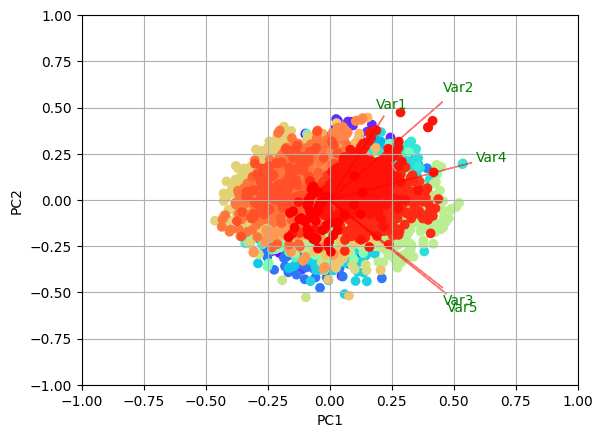

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler

# iris = datasets.load_iris()
X = stacked
y = y
#In general a good idea is to scale the data
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

pca = PCA()
x_new = pca.fit_transform(X)
fig = plt.figure()
# fig.set_tight_layout = True
plt.title = "PCA"
def myplot(score,coeff,labels=labels):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex,ys * scaley, c = y, cmap='rainbow')

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is labels:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
# plt.legend(loc="upper left")

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
# plt.zlabel("PC{}".format(3))
plt.grid()


myplot(x_new[:,0:4],np.transpose(pca.components_[0:4, :]))
# fig.set_size_inches(30.,18.)
plt.savefig('100dpi.png', dpi=100)
plt.savefig('FlanT5_Base_PCA_tacred_all_train_data.png', dpi=200)
plt.show()

In [ ]:
plt.savefig('200dpi.png', dpi=1000)

<Figure size 640x480 with 0 Axes>

In [ ]:
pca.components_[0:4, :]

array([[ 0.2174894 ,  0.45252502,  0.45253672,  0.56930419,  0.46799863],
       [ 0.45052859,  0.52736771, -0.47251286,  0.19994684, -0.50562846],
       [ 0.84781188, -0.30027334,  0.26281476, -0.34395356,  0.06062406],
       [-0.16463105,  0.27106459,  0.70025796, -0.21362886, -0.60284501]])

In [ ]:
pca.components_[0:5, :]

array([[ 0.2174894 ,  0.45252502,  0.45253672,  0.56930419,  0.46799863],
       [ 0.45052859,  0.52736771, -0.47251286,  0.19994684, -0.50562846],
       [ 0.84781188, -0.30027334,  0.26281476, -0.34395356,  0.06062406],
       [-0.16463105,  0.27106459,  0.70025796, -0.21362886, -0.60284501],
       [ 0.06191909, -0.59452866,  0.11184496,  0.68700266, -0.39776847]])

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

train_features =stacked

model = PCA(n_components=5 ).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = ['sentence','subject','object','subject_type','object_type']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [ ]:
model.components_

array([[ 0.90511319,  0.32068199,  0.25998077,  0.06574181,  0.07759626],
       [-0.32124986,  0.09839298,  0.89004367,  0.06862981,  0.30038236],
       [-0.27773154,  0.93143789, -0.20349202,  0.11502941, -0.02545366],
       [ 0.0194478 , -0.04849287, -0.3133115 ,  0.09414283,  0.94352703],
       [-0.00745702, -0.1324907 , -0.02567427,  0.98431363, -0.11339362]])

In [ ]:
df

,0,1
0,PC0,sentence
1,PC1,object
2,PC2,subject
3,PC3,object_type
4,PC4,subject_type
